# Exploratory Data Analysis and Topic Modeling

This section will cover:

* initial exploratory analysis
* grammar and spelling correction 
* feature extraction with SpaCy 
* topic modeling with latent Dirichlet allocation (LDA).
* automatic scoring with LDA

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import re
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation

import language_check

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import joblib
from sklearn.model_selection import train_test_split

import pyLDAvis
from pyLDAvis.sklearn import prepare

plt.style.use('seaborn-colorblind')

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', 100)

pyLDAvis.enable_notebook()
# plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi']= 100

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [2]:
training_set  = pd.read_csv('training_set_rel3.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic', 'domain1_score': 'target_score', 'domain2_score': 'topic2_target'})
training_set.sample()

,essay_id,topic,essay,rater1_domain1,rater2_domain1,rater3_domain1,target_score,rater1_domain2,rater2_domain2,topic2_target,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
4869,7268,3,"In the passage Do not exceed posted speed limit, there are many features from the setting that...",1,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   essay_id        12976 non-null  int64  
 1   topic           12976 non-null  int64  
 2   essay           12976 non-null  object 
 3   rater1_domain1  12976 non-null  int64  
 4   rater2_domain1  12976 non-null  int64  
 5   rater3_domain1  128 non-null    float64
 6   target_score    12976 non-null  int64  
 7   rater1_domain2  1800 non-null   float64
 8   rater2_domain2  1800 non-null   float64
 9   topic2_target   1800 non-null   float64
 10  rater1_trait1   2292 non-null   float64
 11  rater1_trait2   2292 non-null   float64
 12  rater1_trait3   2292 non-null   float64
 13  rater1_trait4   2292 non-null   float64
 14  rater1_trait5   723 non-null    float64
 15  rater1_trait6   723 non-null    float64
 16  rater2_trait1   2292 non-null   float64
 17  rater2_trait2   2292 non-null  

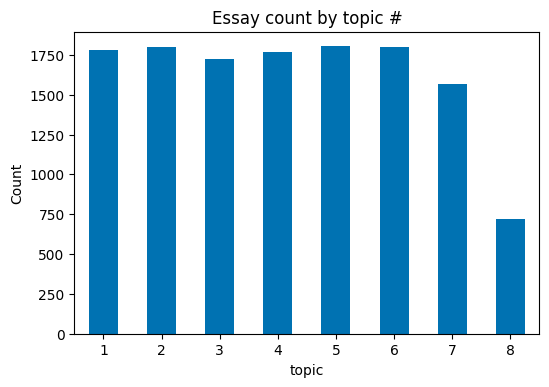

In [4]:
training_set.groupby('topic').agg('count').plot.bar(y='essay', rot=0, legend=False)
plt.title('Essay count by topic #')
plt.ylabel('Count')
plt.show()

Since topic 8 has the fewest essays and the most distinct scores, it might prove to be the most challenging topic to model.

In [5]:
# Count characters and words for each essay
training_set['word_count'] = training_set['essay'].str.strip().str.split().str.len()

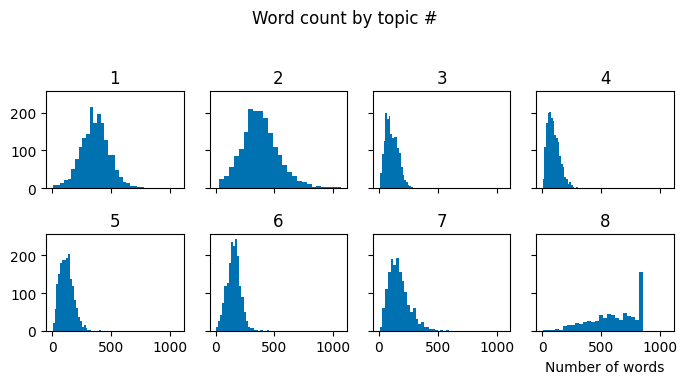

In [6]:
training_set.hist(column='word_count', by='topic', bins=25, sharey=True, sharex=True, layout=(2, 4), figsize=(7,4), rot=0) 
plt.suptitle('Word count by topic #')
plt.xlabel('Number of words')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [7]:
training_set.groupby(['topic'])['target_score'].agg(['min','max','count','nunique'])

,min,max,count,nunique
topic,,,,
1,2,12,1783,11
2,1,6,1800,6
3,0,3,1726,4
4,0,3,1770,4
5,0,4,1805,5
6,0,4,1800,5
7,2,24,1569,23
8,10,60,723,34


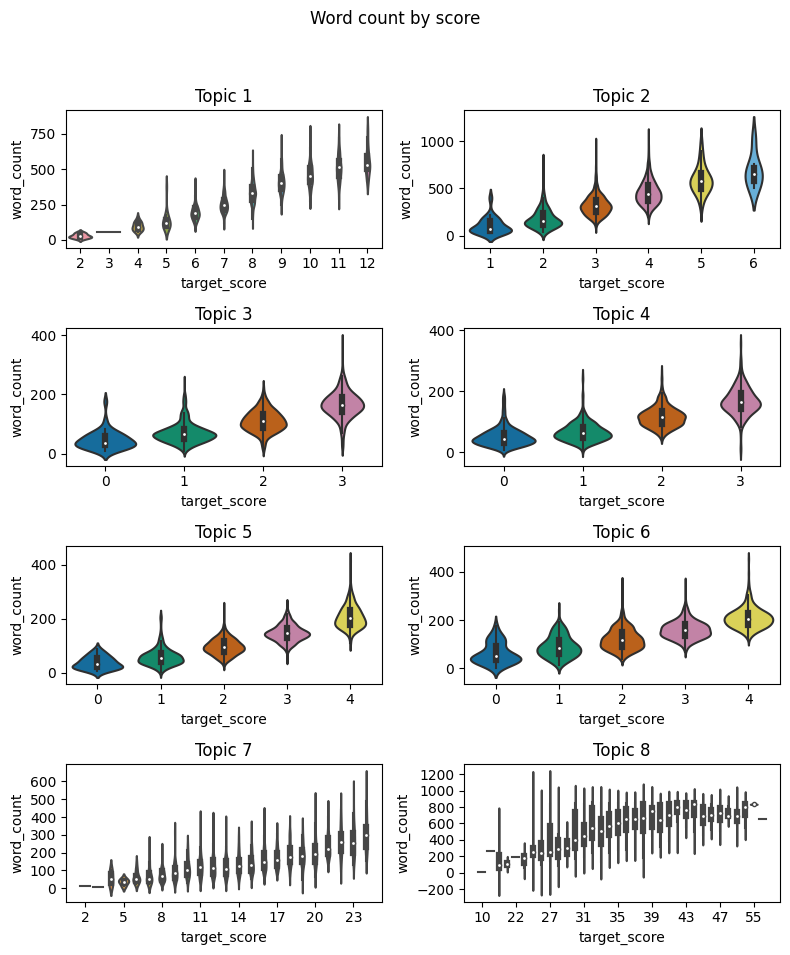

In [8]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(8,10))
for i in range(4):
    for j in range(2):
        topic_number += 1
        sns.violinplot(x='target_score', y='word_count', data=training_set[training_set['topic'] == topic_number], ax=ax[i,j])
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Word count by score')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

We can see a reasonable correlation between word count and score for all but topic 8 where the word count apparently reaches a maximum at the upper third of the scores.

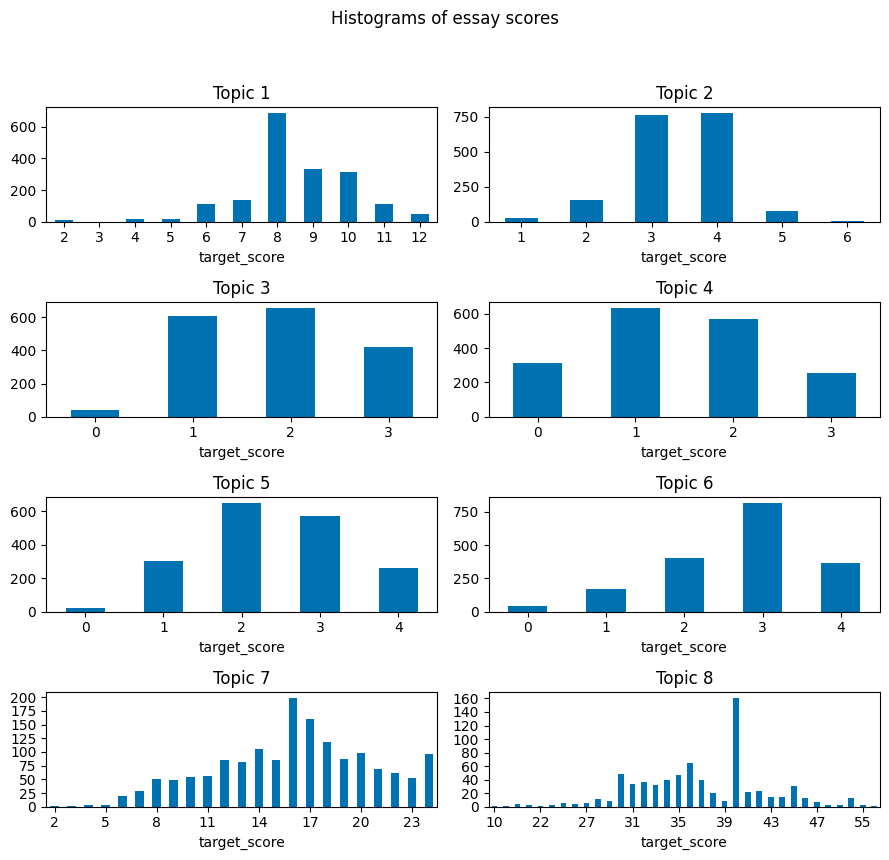

In [9]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(9,9), sharey=False)
for i in range(4):
    for j in range(2):
        topic_number += 1
        training_set[training_set['topic'] == topic_number]\
            .groupby('target_score')['essay_id']\
            .agg('count')\
            .plot.bar(ax=ax[i, j], rot=0)
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Histograms of essay scores')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Many scores are underrepresented. Classification could be difficult without rebalancing.

## Essay processing:

1. Language correction with languagetool (add number of corrections as feature)
2. Sentence tokenization with Spacy
3. Sentence count and length
4. Word tokenize with Spacy
5. Word token classification (punctuation, stop words and anonymized entities, pos, ent)
6. Document similarity (based on arbitrary high scoring essay for each topic)

## Grammar and spelling

As to be expected with student essays, many essays exhibit grammar and spelling errors. 

Parts-of-speech (POS) and named-entity-recognition (NER) is hampered in part by the lack of consitent spelling and punctuation. Therefore, the essays will be corrected using languagetool and the nlp parsing will be performed with Spacy on the corrected essays.

In [10]:
text = 'Some people are still using Myspoce instead of facdbook'

Textblob is an open source nlp package and something to keep an eye on. Unlike Spacy, textblob includes a statistics based spell checker. It only claims 70% accuracy, and in my testing it didn't perform well.

https://textblob.readthedocs.io/en/dev/

In [11]:
from textblob import TextBlob
data = TextBlob(text)
print (data.correct())

Some people are still using Myspoce instead of facdbook


Languagetool.org has a python wrapper for spelling and grammatical errors at 
https://github.com/myint/language-check

It appears to work quite well, although it requires intermediate storage of a list of errors ('matches').

In [ ]:
tool = language_check.LanguageTool('en-US')

matches = tool.check(text)
language_check.correct(text, matches)

In [ ]:
text = training_set.essay[1871]
text

In [ ]:

matches = tool.check(text)
language_check.correct(text, matches)


As seen in the last sentence, languagetool did not correct `",therefor"`. Nonetheless, it should be good enough to proceed.

In [ ]:
"""
use language tool to correct for most spelling and grammatical errors. Also count the applied corrections. 
Using language_check python wrapper for languagetool:
https://www.languagetool.org/dev
"""
tool = language_check.LanguageTool('en-US')

t0 = datetime.now()

training_set['matches'] = training_set['essay'].apply(lambda txt: tool.check(txt))
training_set['corrections'] = training_set.apply(lambda l: len(l['matches']), axis=1)
training_set['corrected'] = training_set.apply(lambda l: language_check.correct(l['essay'], l['matches']), axis=1)

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

# save work
training_set.to_pickle('training_corr.pkl')

Here's a very special example of poor writing skills (or perhaps a digitization error?). None of the spell checkers I tried were able to make much sense out of this.

In [ ]:
print('Original:')
print(training_set.essay[18])
print('Corrected with languagetool:')
print(training_set.corrected[18])

## NLP with SpaCy

Although much of the analysis could be performed with other NLP packages, SpaCy was chosen due to its combination of speed and simplicity.

In [ ]:
training_set = pd.read_pickle('training_corr.pkl')

In [ ]:
sents = []
tokens = []
lemma = []
pos = []
ner = []

stop_words = set(STOP_WORDS)
stop_words.update(punctuation) # remove it if you need punctuation 

nlp = spacy.load('en_core_web_sm')

t0 = datetime.now()

# suppress numpy warnings
np.warnings.filterwarnings('ignore')

for essay in nlp.pipe(training_set['corrected'], batch_size=100, n_threads=3):
    if essay.is_parsed:
        tokens.append([e.text for e in essay])
        sents.append([sent.string.strip() for sent in essay.sents])
        pos.append([e.pos_ for e in essay])
        ner.append([e.text for e in essay.ents])
        lemma.append([n.lemma_ for n in essay])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        sents.append(None)
        ner.append(None)

training_set['tokens'] = tokens
training_set['lemma'] = lemma
training_set['pos'] = pos
training_set['sents'] = sents
training_set['ner'] = ner

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

In [ ]:
training_set.to_pickle('training_spacy.pkl')

In [ ]:
training_set = pd.read_pickle('training_spacy.pkl')

In [ ]:
training_set[['tokens', 'pos', 'sents', 'ner']].head()

# Topic Modeling with Latent Dirichlet Allocation

Latent Dirichlet Allocation, or **LDA**, uses probabilities to allocate any number of documents to a pre-defined number of topics. A very good explanation is given here:

https://tedunderwood.com/2012/04/07/topic-modeling-made-just-simple-enough/

The *Hewlett ASAP* essays are already labeled as belonging to one of eight topics. A baseline excercise will determine how well essays are allocated to a topic using LDA.

A second experiment will be performed using LDA to assign scores.

Another important remark is that LDA is based on probability distributions. Probing these distributions introduces randomness so the results of running this notebook might not exactly match the comments or annotations.

To minimize confusion between the *LDA* derived topics and the *Hewlett ASAP* given topics, the given topic numbers will be replaced with a one-word summary.

LDA uses the probability of finding certain words associated with documents. Stop words will not be very helpful, for example, the word "the" is going to have a high probability across all topics. In order to refine the word list, we'll also use the lemma generated by SpaCy instead of the regular essay. As a reminder, the lemma were generated on language corrected essays.

In [ ]:
# Replace topic numbers with meaningful one-word summary:
topic_dict = {'topic':{1: 'computer', 
                       2: 'censorship', 
                       3: 'cyclist', 
                       4: 'hibiscus', 
                       5: 'mood', 
                       6: 'dirigibles', 
                       7: 'patience', 
                       8: 'laughter'}}

training_set.replace(topic_dict, inplace=True)

# Lemmatized essays re-joined (list to essay)
training_set['l_essay'] = training_set['lemma'].apply(' '.join)

Convert essays to a matrix of token (lemma) counts:

In [ ]:
# Baseline: number of unique lemma
vectorizer = CountVectorizer(max_df=.2, 
                             min_df=3, 
                             stop_words=STOP_WORDS, 
                             max_features=2000) # default: binary=False
doc_term_matrix = vectorizer.fit_transform(training_set.l_essay) # using lemmatized essays

# Most frequent tokens:
words = vectorizer.get_feature_names()
doc_term_matrix_df = pd.SparseDataFrame(doc_term_matrix, columns=words)
word_freq = doc_term_matrix_df.sum(axis=0).astype(int)
word_freq.sort_values(ascending=False).head(10) 

Apply LDA on the word frequency matrix.

In [ ]:
lda_base = LatentDirichletAllocation(n_components=8,
                                     n_jobs=-1,
                                     learning_method='batch',
                                     max_iter=40,
                                     perp_tol=0.01,
                                     verbose=1,
                                     evaluate_every=5)
lda_base.fit(doc_term_matrix)

# save base model
joblib.dump(lda_base, 'lda_baseline.pkl')

Topic probabilities for all words. The numbered topics are generated from the latent Dirichlet allocation. 

In [ ]:
topic_labels = ['Topic {}'.format(i) for i in range(1, 9)]
topics_count = lda_base.components_
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=words,
                      columns=topic_labels)
topics.sample(10)

In [ ]:
one_word = list(topic_dict['topic'].values())
sns.heatmap(topics.reindex(one_word), cmap='Blues')
plt.title('Topic probabilities for one-word-summary')
plt.show()

The heatmap suggests assignments for all but 1 topics. 

Below are the most probable words for each topic. We can already see our one-word summaries of the actual topic near the top of the list. 

In [ ]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

Now we can assign LDA topic probabilities to each essay and aggregate. It is now clear that, for example, LDA allocated topic 3 is aligned with the given topic "computers".

In [ ]:
train_preds = lda_base.transform(doc_term_matrix)
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=training_set.topic)
train_eval.sample(10)

In [ ]:
train_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Probabilities', rot=0, colormap='tab10', figsize=(10,5));

The baseline model was successful in that each given topic is allocated with high probability to an LDA topic:

In [ ]:
df = train_eval.groupby(level='topic').agg('median')
fig, ax = plt.subplots(figsize=(8,8))
g = sns.heatmap(df, annot=True, fmt='.1%', annot_kws={"size": 10}, cmap='Blues', square=True)
loc, labels = plt.yticks()
g.set_yticklabels(labels, rotation=0)
g.set_title('Topic Assignments');

df = train_eval\
            .idxmax(axis=1)\
            .reset_index()\
            .groupby('topic', as_index=False)\
            .agg(lambda x:x.value_counts().index[0])\
            .rename(columns={0:'assignment'})
df

## Visualization with PyLDAVis

#### Lambda

- **$\lambda$ = 0**: how probable is a word to appear in a topic - words are ranked on lift P(word | topic) / P(word)
- **$\lambda$ = 1**: how exclusive is a word to a topic -  words are purely ranked on P(word | topic)

The ranking formula is $\lambda * P(\text{word} \vert \text{topic}) + (1 - \lambda) * \text{lift}$

User studies suggest $\lambda = 0.6$ works for most people.

In [ ]:
prepare(lda_base, doc_term_matrix, vectorizer)

### "Score Allocation"

Can we take this to the next level and assign target scores based on word probabilities? To keep it simple, we'll limit the essays to topic number 4, "hibiscus". This topic has only four target scores and a reasonably balanced distribution.

In [ ]:
hibiscus = training_set[training_set.topic == 'hibiscus']

# Split essays into training and test sets
train_essays, test_essays = train_test_split(hibiscus, 
                                         stratify=hibiscus.target_score, 
                                         test_size=0.2, 
                                         random_state=42)

In [ ]:
vectorizer = CountVectorizer(max_df=.2, 
                             min_df=3, 
                             stop_words=STOP_WORDS, 
                             max_features=400) # limit to account for smaller set of essays

# Train and test doc-term matrices
train_dtm = vectorizer.fit_transform(train_essays.l_essay)
test_dtm = vectorizer.fit_transform(test_essays.l_essay)

In [ ]:
lda_score = LatentDirichletAllocation(n_components=4,
                                     n_jobs=-1,
                                     learning_method='batch',
                                     evaluate_every=5,
                                     verbose=1, 
                                     max_iter=500)
lda_score.fit(train_dtm)

# save training model
joblib.dump(lda_score, 'lda_score.pkl')

In [ ]:
topic_labels = ['Score A', 'Score B', 'Score C', 'Score D'] #.format(i) for i in range(1, 5)]

train_preds = lda_score.transform(train_dtm)
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_essays.target_score)
train_eval.sample(5)

In [ ]:
train_eval.groupby(level='target_score')\
            .mean()\
            .plot\
            .bar(title='Avg. Topic Probabilities', rot=0, colormap='tab10', figsize=(8,5));

In [ ]:
df = train_eval.groupby(level='target_score').agg('median')
sns.heatmap(df, annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Train Data: Score Assignments');

df = train_eval\
            .idxmax(axis=1)\
            .reset_index()\
            .groupby('target_score', as_index=False)\
            .agg(lambda x:x.value_counts().index[0])\
            .rename(columns={0:'assignment'})
df

In [ ]:
test_preds = lda_score.transform(test_dtm)
test_eval = pd.DataFrame(test_preds, columns=topic_labels, index=test_essays.target_score)
test_eval.head()

In [ ]:
test_eval.groupby(level='target_score')\
            .mean()\
            .plot\
            .bar(title='Avg. Topic Probabilities', rot=0);

In [ ]:
df = test_eval.groupby(level='target_score').agg('median')
sns.heatmap(df, annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Topic Assignments')
plt.show()

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(8,6), sharey=True)
source = ['Train', 'Test']
for i, df in enumerate([train_eval, test_eval]):
    df = df.groupby(level='target_score').agg('median')
    sns.heatmap(df, annot=True, fmt='.1%', cmap='Blues', square=True, ax=axes[i], cbar=False)
    axes[i].set_title('{} Data: Topic Assignments'.format(source[i]))
plt.tight_layout()
plt.show()

While the charts above are very similar to a confusion matrix, the ordering of the LDA derived topics (A,B,C,D) doesn't necessarily match the human-labeled topic ordering (0,1,2,3). Thus, the high percentages, shown here as deep blues, are not expected to be found along the diagonal. Instead the goal is to find topic distinction, indicated by a single dark square in each column, and model accuracy, indicated by identical color patterns between train and test data sets.

As seen above, there is some agreement between train and test data that essays with highest and lowest scores are distinct and assigned "Score A" and "Score B" respectively.  Overall, both topic distinction and model accuracy are rather poor. It is highly improbable this approach could be extended to any of the other topics due to the larger range of scores and class imbalance. 

Furthermore, repeated LDA runs show a lack of reproducability, which is a sign of poor distinction of topics. In summary, topic modelling, or more specifically using word frequencies and probabilities is not a useful tool to grade student essays. In the next notebook we'll continue with machine learning algorithms.